In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import sqlite3
import tensorflow as tf
import string
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

In [2]:
# create our data set
curr_path = os.path.realpath('')
conn = sqlite3.connect(curr_path+"/lending-club-loan-data/database.sqlite")

###@@@@@ 
#         add loan_amnt and annual_inc back later 
###@@@@

df_tf = pd.read_sql_query("select loan_status, term, int_rate, emp_length, home_ownership, verification_status, dti, loan_amnt, annual_inc from loan where id in (select id from loan order by random()) AND emp_length != 'n/a' AND int_rate != 'NULL' AND loan_status =='Fully Paid';", conn)
df_tf_default = pd.read_sql_query("select loan_status, term, int_rate, emp_length, home_ownership, verification_status, dti, loan_amnt, annual_inc from loan where id in (select id from loan order by random()) AND emp_length != 'n/a' AND int_rate != 'NULL' AND loan_status == 'Charged Off' OR loan_status == 'Default';", conn)

df_tf_test = pd.read_sql_query("select loan_status, term, int_rate, emp_length, home_ownership, verification_status, dti, loan_amnt, annual_inc from loan where id in (select id from loan order by random()) AND emp_length != 'n/a' AND int_rate != 'NULL' AND loan_status == 'Charged Off' OR loan_status == 'Default' OR loan_status == 'Fully Paid';", conn)

conn.close()

In [3]:
# df_desc = pd.read_sql_query("select loan_amnt, loan_status, sub_grade from loan where desc != 'NULL' AND loan_status !='Current' AND loan_status !='Late (31-120 days)' AND loan_status != 'Late (16-30 days)'", conn)
df_tf_paid = df_tf.sample(frac=(40000/float(len(df_tf)))).reset_index(drop=True)
df_tf_default = df_tf_default.sample(frac=40000/float(len(df_tf_default))).reset_index(drop=True)
df_tf_test = df_tf_test.sample(frac=40000/float(len(df_tf_test))).reset_index(drop=True)

In [4]:
print (len(df_tf))
print(len(df_tf_default))

# this set is split between half paid and half default/charged-offs
df_tf = df_tf_paid.append(df_tf_default, ignore_index=True)
print (len(df_tf))
print (len(df_tf_test))

#results = [0]*40000 + [1]*40000
# df_tf = split_data

200352
40000
80000
40000


In [5]:
def feature(datum):
    data = []
    for i in range(len(datum)):  # data set of 10000 for faster run time. Replace with range(len(df_tf)) later
        # 0 if term is 36 months, 1 if 60 months
        term = 0 if datum.iloc[i][1] == ' 36 months' else 1
    
        # change interest rate from str to float
        if type(datum.iloc[i][2]) == str:     # condition to prevent calling replace on NoneTypes
            int_rate = float(datum.iloc[i][2].replace('%', ''))
        
        # get employment length
        txt = ''.join([c for c in datum.iloc[i][3].lower() if not c in set(string.punctuation)])
        emp_length_list = ([int(s) for s in txt.split() if s.isdigit()])
        emp_length = 0 if emp_length_list == [] else emp_length_list[0]

        # 0 if renting, 1 if owner
        ownership = 0 if datum.iloc[i][4] == 'RENT' else 1

        # verification sttus, 0 for not verified, 1 for source verified and 2 for verified
        #verification = 0 if df_tf.iloc[i][5] == 'Not Verified' else 1 if df_tf.iloc[i][5] == 'Source Verified' else 2
        verification = 0 if datum.iloc[i][5] == 'Not Verified' else 1
        
        loan_amount = 35000 if datum.iloc[i][7] > 500000 else datum.iloc[i][7]
        # append in feature vector
        data.append([term, int_rate, emp_length, ownership, verification, datum.iloc[i][6], loan_amount, datum.iloc[i][8]])
        # data.append([term, int_rate, emp_length, ownership, verification, df_tf.iloc[i][6]])
    return data

def get_labels(datum):
    results = []
    for i in range(len(datum)):  # data set of 10000 for faster run time. Replace with range(len(df_tf)) later
        loan_status = 0 if datum.iloc[i][0] == 'Fully Paid' else 1 # bad if not fully paid
        results.append(loan_status)     # add to results 
    return results

In [6]:
data = feature(df_tf)
results = get_labels(df_tf)

In [7]:
data_test = feature(df_tf_test)
results_test = get_labels(df_tf_test)

In [8]:
print( float("12.95323%".replace('%', '')))

12.95323


In [9]:
#print (df_tf)

In [21]:
X_train = data
y_train = results

X_val = data_test[:int(len(data_test)*0.3)]
y_val = results_test[:int(len(results_test)*.3)]

X_test1 = data_test[int(len(data_test)*.3) : int(len(data_test)*0.5)]
y_test1 = results_test[int(len(results_test)*.3) : int(len(data_test)*0.5)]

X_test2 = data_test[int(len(data_test)*.5) : int(len(data_test)*0.7)]
y_test2 = results_test[int(len(results_test)*.5) : int(len(data_test)*0.7)]

X_test3 = data_test[int(len(data_test)*.7) : int(len(data_test)*0.9)]
y_test3 = results_test[int(len(results_test)*.7) : int(len(data_test)*0.9)]

X_test4 = data_test[int(len(data_test)*.9) : int(len(data_test)*1)]
y_test4 = results_test[int(len(results_test)*.9) : int(len(data_test)*1)]

X_test_combined = data_test[int(len(data_test)*0.3):]
y_test_combined = results_test[int(len(results_test)*.3):]

In [11]:
### normalize and scale training set

X_train_norm = preprocessing.normalize(X_train)
scaler = preprocessing.StandardScaler().fit(X_train_norm)
X_train_norm_std = scaler.transform(X_train_norm)

X_train_arr = np.array(X_train_norm_std, "float32")
y_train_arr = np.array(y_train, "float32")

In [12]:
print (len(data_test))
print (len(X_train_arr))
print (len(y_train_arr))

40000
80000
80000


In [13]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
# Function to test with logistic regressor and neural net
# params: X, y, neural net classifier and logistic regressor
def runTests(X, y, dnn_clf, log_clf, setName):
    X_norm = preprocessing.normalize(X)   # normalize, scale and turn X into array 
    X_arr = np.array(scaler.transform(X_norm), "float32")
    y_arr = np.array(y, "float32")
    y_pred = dnn_clf.predict_classes(X_arr, as_iterable=False)
    average_precision = average_precision_score(y_arr, y_pred)
    precision, recall, fscore, support = score(y, y_pred)
    print('###')
    print ('\t\tRunning set: ' + setName)
    print('Neural Net') 
    print('Accuracy: \t' + str(accuracy_score(y, y_pred)))
    print('Avg. precision-recall: \t{0:0.2f}'.format(average_precision))
    print('precision: \t{}'.format(precision))
    print('recall: \t{}'.format(recall))
    print('fscore: \t{}'.format(fscore))
    print('support: \t{}'.format(support))

    print('')
    y_pred = log_clf.predict(X_norm)
    # average_precision = average_precision_score(y, y_pred)
    precision, recall, fscore, support = score(y, y_pred)
    print('Logistic Regression') 
    print('Accuracy: \t' + str(accuracy_score(y, y_pred)))
    # print('Avg. precision-recall: \t{0:0.2f}'.format(average_precision))
    print('precision: \t{}'.format(precision))
    print('recall: \t{}'.format(recall))
    print('fscore: \t{}'.format(fscore))
    print('support: \t{}'.format(support))
    print('###')

In [14]:
# training with DNNClassifier
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_arr)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[512, 256, 128], n_classes=2, dropout = .9, feature_columns=feature_cols, activation_fn=tf.nn.tanh)
dnn_clf.fit(X_train_arr, y_train_arr, batch_size=6, steps=1000)

# training with Logistic Regression
log_clf = LogisticRegression()
log_clf.fit(X_train_norm, y_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a2396dfd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving 

/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt.
INFO:tensorflow:loss = 1.18814, step = 1
INFO:tensorflow:global_step/sec: 388.6
INFO:tensorflow:loss = 0.925402, step = 101 (0.259 sec)
INFO:tensorflow:global_step/sec: 403.696
INFO:tensorflow:loss = 0.599526, step = 201 (0.248 sec)
INFO:tensorflow:global_step/sec: 405.739
INFO:tensorflow:loss = 0.625079, step = 301 (0.246 sec)
INFO:tensorflow:global_step/sec: 407.561
INFO:tensorflow:loss = 0.389301, step = 401 (0.246 sec)
INFO:tensorflow:global_step/sec: 402.911
INFO:tensorflow:loss = 1.12933, step = 501 (0.248 sec)
INFO:tensorflow:global_step/sec: 406.496
INFO:tensorflow:loss = 0.782817, step = 601 (0.246 sec)
INFO:tensorflow:global_step/sec: 409.216
INFO:tensorflow:loss = 0.569756, step = 701 (0.244 sec)
INFO:tensorflow:global_step/sec: 417.214
INFO:tensorflow:loss = 0.589226, step = 801 (0.240 sec)
INFO:tensorflow:global_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
runTests(X_train, y_train, dnn_clf, log_clf, 'Training')
runTests(X_val, y_val, dnn_clf, log_clf, 'Validation')

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


###
		Running set: Training
Neural Net
Accuracy: 	0.609875
Avg. precision-recall: 	0.57
precision: 	[ 0.59741987  0.62598177]
recall: 	[ 0.6738   0.54595]
fscore: 	[ 0.63331532  0.58323318]
support: 	[40000 40000]

Logistic Regression
Accuracy: 	0.58435
precision: 	[ 0.57926142  0.59013678]
recall: 	[ 0.61645  0.55225]
fscore: 	[ 0.5972774   0.57056514]
support: 	[40000 40000]
###
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving int

In [16]:
runTests(X_test1, y_test1, dnn_clf, log_clf, 'Test 1')
runTests(X_test2, y_test2, dnn_clf, log_clf, 'Test 2')

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000
###
		Running set: Test 1
Neural Net
Accuracy: 	0.63975
Avg. precision-recall: 	0.22
precision: 	[ 0.86606965  0.25747899]
recall: 	[ 0.66331352  0.53231411]
fscore: 	[ 0.75125151  0.34707748]
support: 	[6561 1439]

Logistic Regression
Accuracy: 	0.59625
precision: 	[ 0.85948629  0.23403623]
recall: 	[ 0.60691968  0.5476025 ]
fscore: 	[ 0.71145256  0.32792343]
support: 	[6561 1439]
###
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -

In [20]:
runTests(X_test3, y_test3, dnn_clf, log_clf, 'Test 3')
runTests(X_test4, y_test4, dnn_clf, log_clf, 'Test 4')

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


###
		Running set: Test 3
Neural Net
Accuracy: 	0.653625
Avg. precision-recall: 	0.23
precision: 	[ 0.88096184  0.26819407]
recall: 	[ 0.67115821  0.57060932]
fscore: 	[ 0.76188021  0.36488655]
support: 	[6605 1395]

Logistic Regression
Accuracy: 	0.6005
precision: 	[ 0.86965951  0.2342874 ]
recall: 	[ 0.60711582  0.56917563]
fscore: 	[ 0.71504993  0.3319398 ]
support: 	[6605 1395]
###
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by movin

In [23]:
runTests(data_test, results_test, dnn_clf, log_clf, 'Test Combined')

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


###
		Running set: Test Combined
Neural Net
Accuracy: 	0.6446
Avg. precision-recall: 	0.22
precision: 	[ 0.87351511  0.25955478]
recall: 	[ 0.66491686  0.54954571]
fscore: 	[ 0.75507391  0.3525822 ]
support: 	[32956  7044]

Logistic Regression
Accuracy: 	0.599775
precision: 	[ 0.86645331  0.23440185]
recall: 	[ 0.60793179  0.56161272]
fscore: 	[ 0.71452772  0.3307554 ]
support: 	[32956  7044]
###


Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


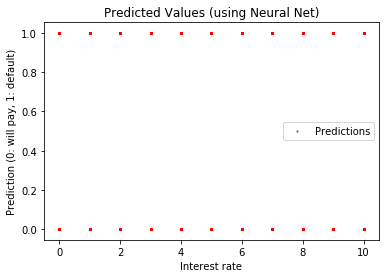

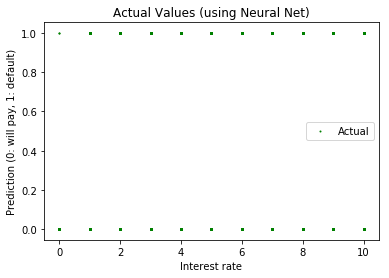

In [18]:
# Plot out interest rate
X_norm = preprocessing.normalize(X_test1)   # normalize, scale and turn X into array 
X_arr = np.array(scaler.transform(X_norm), "float32")
y_arr = np.array(y_test1, "float32")
y_pred = dnn_clf.predict_classes(X_arr, as_iterable=False)

import matplotlib.pyplot as plt

X_plot = []
for i in range(len(X_test1)):
    X_plot.append(X_test1[i][2])

# Plot the results

plt.figure()
#axes = plt.gca()
#axes.set_xlim([0,700000])
plt.scatter(X_plot, y_pred, s=1, c="r", label="Predictions")
plt.xlabel("Interest rate")
plt.ylabel("Prediction (0: will pay, 1: default)")
plt.title("Predicted Values (using Neural Net)")
plt.legend()
plt.show()

plt.figure()
#axes = plt.gca()
#axes.set_xlim([0,700000])
plt.scatter(X_plot, y_test1, s=1, c="g", label="Actual")
plt.xlabel("Interest rate")
plt.ylabel("Prediction (0: will pay, 1: default)")
plt.title("Actual Values (using Neural Net)")
plt.legend()
plt.show()

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/cv/j7y0jf0x0gbc39xntlnng44c0000gn/T/tmpa65mobhq/model.ckpt-1000


/Users/noellin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


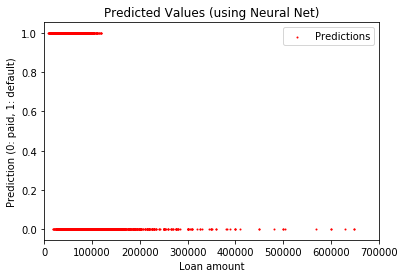

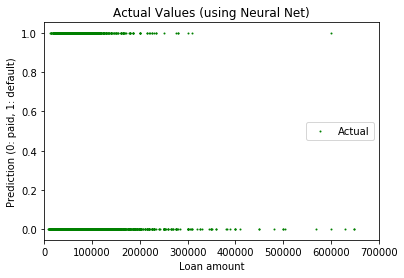

In [19]:
# Plot out loan amount
X_norm = preprocessing.normalize(X_test1)   # normalize, scale and turn X into array 
X_arr = np.array(scaler.transform(X_norm), "float32")
y_arr = np.array(y_test1, "float32")
y_pred = dnn_clf.predict_classes(X_arr, as_iterable=False)

import matplotlib.pyplot as plt

X_plot = []
for i in range(len(X_test1)):
    X_plot.append(X_test1[i][7])

# Plot the results

plt.figure()
axes = plt.gca()
axes.set_xlim([0,700000])
plt.scatter(X_plot, y_pred, s=1, c="r", label="Predictions")
plt.xlabel("Loan amount")
plt.ylabel("Prediction (0: paid, 1: default)")
plt.title("Predicted Values (using Neural Net)")
plt.legend()
plt.show()

plt.figure()
axes = plt.gca()
axes.set_xlim([0,700000])
plt.scatter(X_plot, y_test1, s=1, c="g", label="Actual")
plt.xlabel("Loan amount")
plt.ylabel("Prediction (0: paid, 1: default)")
plt.title("Actual Values (using Neural Net)")
plt.legend()
plt.show()
